In [ ]:
'''
Анализируем приложение по доставке готовых продуктов. Имеются результаты двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: 
пользователям показывались либо прямоугольные, либо новые квадратные 

Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Есть предположение, что среди групп могут встретиться различия. 
Задача – проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Описание данных
5_task_1:

id – id клиента в эксперименте
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
events – сколько блюд суммарно было заказано за период

5_task_2:

id – id клиента в эксперименте
segment – сегмент (high/low)
group – вид кнопки (control – старая версия, test – новая версия)
events – сколько блюд суммарно было заказано за период
'''

In [66]:
import scipy
import pandas as pd
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from scipy import stats
import pingouin as pg
import seaborn as sns

In [12]:
# первичная выгрузка данных:
df_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tverskoj/github/training/5_task_1.csv')
df_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tverskoj/github/training/5_task_2.csv')
df_1.head(), df_2.head()

(      id group  events
 0  16046     A      14
 1  18712     A      41
 2   3268     A      30
 3  22633     A      37
 4  28071     A      38,
       id group segment  events
 0  83440  test    high    78.0
 1  96723  test    high    71.0
 2  68719  test    high    80.0
 3  50399  test    high    80.0
 4  95613  test    high    78.0)

In [22]:
# проверим данные на гомогенность дисперсий:
print(pg.homoscedasticity(data=df_1, dv='events', group='group'), '\n', \
      pg.homoscedasticity(data=df_2, dv='events', group='group'))

# результаты тестов не позволяют отклонить гипотезу о гомогенности дисперсий

              W      pval  equal_var
levene  2.26226  0.104133       True 
                W      pval  equal_var
levene  2.544005  0.110717       True


A NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
B NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
C NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)


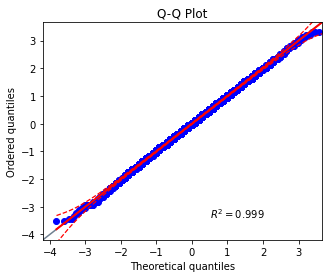

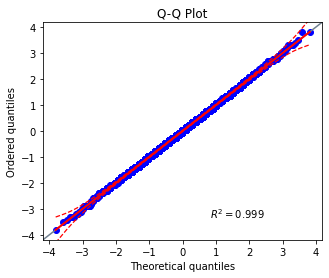

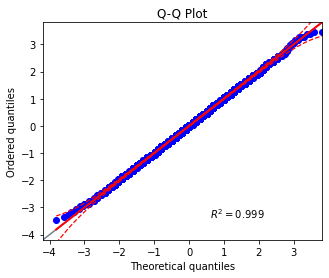

In [30]:
# Проверим данные на нормальность:


# qq - plot:
pg.qqplot(df_1.query('group=="A"').events)
pg.qqplot(df_1.query('group=="B"').events)
pg.qqplot(df_1.query('group=="C"').events)


print('A', scipy.stats.normaltest(df_1.query('group=="A"').events))
print('B', scipy.stats.normaltest(df_1.query('group=="B"').events))
print('C', scipy.stats.normaltest(df_1.query('group=="B"').events))


# гипотезу о нормальности распределения в выборках отклоднить не можем

In [31]:
# однофакторный дисперсионный анализ:
pg.anova(data=df_1, dv="events", between="group")

# делаем вывод, что между группами должны быть отличия

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [35]:
# проведем попарный тест с использованием критерия Тьюки:
print(pairwise_tukeyhsd(df_1.events, df_1.group))


# вывод - все группы попарно статистически отличаются между собой
# группа B в среднем имеет наибольшее число заказов

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


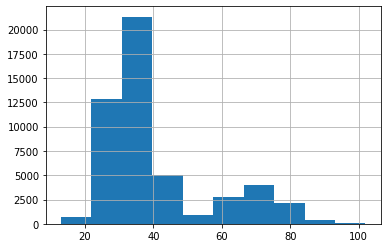

In [45]:
# посмотрим на распределение данных во втором датасете в разбивке по группам:
df_2.query('group=="test"').events.hist()

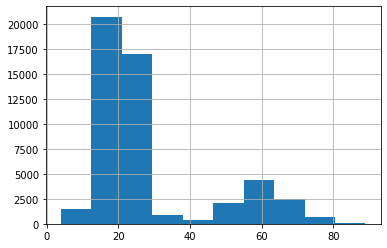

In [46]:
df_2.query('group=="control"').events.hist()

In [55]:
# посмотрим параментры данных в разбивке по группе и сегменту:
df_2.groupby(['group', 'segment'], as_index=False).agg({'events':'describe'})

group segment   events                                               \
                      count       mean       std   min   25%   50%   75%   
0  control    high  10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   
1  control     low  40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   
2     test    high  10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0   
3     test     low  40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   

          
     max  
0   89.0  
1   41.0  
2  102.0  
3   59.0

In [72]:
df_2.groupby(['group', 'segment'], as_index=False).agg({'events':'median'})

,group,segment,events
0,control,high,60.0
1,control,low,20.0
2,test,high,70.0
3,test,low,33.0


In [73]:
# проведем многофакторный дисперсионный анализ, и в случае выявления различий попарный тест Тьюки:
pg.anova(data=df_2, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [64]:
#для удобства добавим колонку, в которой будет совмещена информация о группе и сегменте:
df_2['combined'] = df_2.group + ' / ' + df_2.segment


# попарный тест Тьюки по новой колонке:
print(pairwise_tukeyhsd(df_2.events, df_2.combined))

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392 0.001 -40.1073 -39.7711   True
control / high   test / high   9.9677 0.001   9.7551  10.1803   True
control / high    test / low -26.9449 0.001  -27.113 -26.7768   True
 control / low   test / high  49.9069 0.001  49.7388   50.075   True
 control / low    test / low  12.9944 0.001   12.888  13.1007   True
   test / high    test / low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


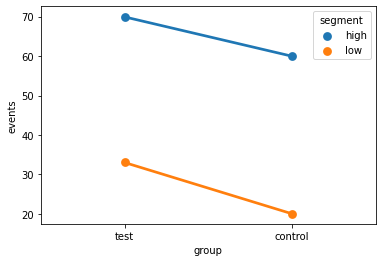

In [71]:
# визуализируем динамику events по группам, в разбивке по сегменту:
sns.pointplot(x=df_2.group, y=df_2.events, hue=df_2.segment)


# Итого: статистически значимымы являются как влияния факторов сегмента и группы, так и их взаимодействия.
# В тестовых группах наблюдается прирост показателя, ввиду чего изменения положительно влияют на количество заказов.